## Download and import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.basemap import Basemap
from os import path
import math
from scipy.spatial import Voronoi
from scipy.spatial import KDTree

## Download and load Dataset as `travels` and `stations`


In [2]:
# import kagglehub

# Download latest version
# ds_path = kagglehub.dataset_download("sebastianquirarte/over-9-years-of-real-public-bike-use-data-mibici")
ds_path = './'

In [3]:
stations = pd.read_csv(path.join(ds_path, 'nomenclature_2024.csv'), index_col=2)

In [4]:
load_nrows = None # None: to load all

### Load travels

In [5]:
pd.read_csv(
    path.join(ds_path, 'mibici_2014-2024/mibici_2014-2024.csv'),
    index_col=0,
    nrows=0
).columns.to_list()

['Trip_Id',
 'User_Id',
 'Sex',
 'Birth_year',
 'Trip_start',
 'Trip_end',
 'Origin_Id',
 'Destination_Id',
 'Age',
 'Duration']

In [6]:
travels = pd.read_csv(
    path.join(ds_path, 'mibici_2014-2024/mibici_2014-2024.csv'),
    index_col=0,
    nrows=load_nrows,
    usecols=['Trip_Id', 'Trip_start', 'Trip_end', 'Origin_Id', 'Destination_Id', 'Age'],
    dtype={
        'Origin_Id': np.uint16,
        'Destination_Id': np.uint16,
        'Age': np.uint8
    },
    parse_dates=['Trip_start', 'Trip_end'],
)

In [7]:
travels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25863690 entries, 32244893 to 4725
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Trip_start      datetime64[ns]
 1   Trip_end        datetime64[ns]
 2   Origin_Id       uint16        
 3   Destination_Id  uint16        
 4   Age             uint8         
dtypes: datetime64[ns](2), uint16(2), uint8(1)
memory usage: 715.3 MB


In [8]:
print("Loaded this range of data:")
print(travels['Trip_start'].min())
print(travels['Trip_end'].max())

Loaded this range of data:
2014-12-01 12:10:13
2024-02-01 00:24:31


## Augment Dataset with data engineering

### Time engineering

In [10]:
# Feature engineering
travels['start_hour'] = (travels['Trip_start'].dt.hour).astype(np.uint8)
travels['start_dayofweek'] = (travels['Trip_start'].dt.dayofweek).astype(np.uint8)
travels['start_is_weekend'] = (travels['start_dayofweek'] >= 5).astype(np.uint8)

travels['end_hour'] = (travels['Trip_end'].dt.hour).astype(np.uint8)
travels['end_dayofweek'] = (travels['Trip_end'].dt.dayofweek).astype(np.uint8)
travels['end_is_weekend'] = (travels['end_dayofweek'] >= 5).astype(np.uint8)

travels['Minute'] = (travels['Trip_start'].dt.minute).astype(np.uint8)
travels['Hour'] = (travels['Trip_start'].dt.hour).astype(np.uint8)

travels['Day'] = (travels['Trip_start'].dt.day).astype(np.uint8)
travels['Month'] = (travels['Trip_start'].dt.month).astype(np.uint8)
travels['Year'] = (travels['Trip_start'].dt.year).astype(np.uint16)


In [ ]:
travels['Duration'] = (travels['Trip_end'] - travels['Trip_start'])
# travels.drop(columns=['Trip_start', 'Trip_end'], inplace=True)

In [14]:
travels['Duration'] = travels['Duration'].apply(lambda x: x.total_seconds() / 60)

AttributeError: 'float' object has no attribute 'total_seconds'

In [ ]:
# Cyclical encoding
travels['Start_hour_sin'] = np.sin((2 * np.pi * travels['start_hour']).astype(np.float16) / 24).astype(np.float16)
travels['Start_hour_cos'] = np.cos((2 * np.pi * travels['start_hour']).astype(np.float16) / 24).astype(np.float16)

In [ ]:
travels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25863690 entries, 32244893 to 4725
Data columns (total 14 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Origin_Id         uint16 
 1   Destination_Id    uint16 
 2   Age               uint8  
 3   Start_hour        uint8  
 4   Start_dayofweek   uint8  
 5   Start_is_weekend  uint8  
 6   Minute            uint8  
 7   Hour              uint8  
 8   Day               uint8  
 9   Month             uint8  
 10  Year              uint16 
 11  Duration          uint16 
 12  Start_hour_sin    float16
 13  Start_hour_cos    float16
dtypes: float16(2), uint16(4), uint8(8)
memory usage: 690.6 MB


### Geographical engineering

In [ ]:
station_coords = stations.set_index('id')[['longitude', 'latitude']].apply(tuple, axis=1).to_dict()

# Map origin and destination coordinates to travels
travels['origin'] = travels['Origin_Id'].map(station_coords)
travels['destination'] = travels['Destination_Id'].map(station_coords)

# Extract coordinates into separate columns
travels[['origin_lon', 'origin_lat']] = pd.DataFrame(travels['origin'].tolist(), index=travels.index)
travels.drop(columns=['origin'], inplace=True)

travels[['dest_lon', 'dest_lat']] = pd.DataFrame(travels['destination'].tolist(), index=travels.index)
travels.drop(columns=['destination'], inplace=True)


travels['Trip_summary'] = travels.index.astype(np.uint32)

def manhattanHaversine(lat1, lon1, lat2, lon2):
    # Kilometers per radian
    kpr = 6371.0088
    
    # Convert degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)
    
    north_south = kpr * abs(lat1 - lat2)
    cos_avg_lat = math.cos((lat1 + lat2) / 2)
    east_west = kpr * abs(lon1 - lon2) * cos_avg_lat

    result = north_south + east_west

    return result

travels['Distance'] = travels.apply(lambda row: manhattanHaversine(row['origin_lat'], row['origin_lon'], row['dest_lat'], row['dest_lon']), axis=1).astype(np.float16)

In [15]:
travels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25863690 entries, 32244893 to 4725
Data columns (total 20 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Origin_Id         uint16 
 1   Destination_Id    uint16 
 2   Age               uint8  
 3   Start_hour        uint8  
 4   Start_dayofweek   uint8  
 5   Start_is_weekend  uint8  
 6   Minute            uint8  
 7   Hour              uint8  
 8   Day               uint8  
 9   Month             uint8  
 10  Year              uint16 
 11  Duration          uint16 
 12  Start_hour_sin    float16
 13  Start_hour_cos    float16
 14  origin_lon        float64
 15  origin_lat        float64
 16  dest_lon          float64
 17  dest_lat          float64
 18  Trip_summary      uint32 
 19  Distance          float16
dtypes: float16(3), float64(4), uint16(4), uint32(1), uint8(8)
memory usage: 1.6 GB


### Weather engineering

In [16]:
# Figure out corners and center
min_lat = stations['latitude'].min()
max_lat = stations['latitude'].max()

mean = stations[['latitude', 'longitude']].mean()

min_lon = stations['longitude'].min()
max_lon = stations['longitude'].max()

left_up = (min_lat, max_lon)
right_up = (max_lat, max_lon)
left_down = (min_lat, min_lon)
right_down = (max_lat, min_lon)

print(f"left_up: {left_up}")
print(f"right_up: {right_up}")
print(f"left_down: {left_down}")
print(f"right_down: {right_down}")
print(f"mean: {mean.values}")

left_up: (20.63613, -103.301239)
right_up: (20.73837, -103.301239)
left_down: (20.63613, -103.4247637)
right_down: (20.73837, -103.4247637)
mean: [  20.67962362 -103.36229162]


In [17]:
# Load weather stations df
weather_stations = pd.read_csv(
    './open-meteo-stations.csv',
    index_col=0,
    usecols=['location_id', 'latitude', 'longitude'],
    dtype={
        'location_id': np.uint16,
        'latitude': np.float32,
        'longitude': np.float32
    }
)

weather_stations

,latitude,longitude
location_id,,
0,20.632689,-103.350159
1,20.773285,-103.286133
2,20.632689,-103.440979
3,20.773285,-103.468140
4,20.702986,-103.363617


In [18]:
# travels.to_csv(path.join(ds_path, 'mibici_2014-2024/dataeng1_2014-2024.csv'), index=True)

In [19]:
travels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25863690 entries, 32244893 to 4725
Data columns (total 20 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Origin_Id         uint16 
 1   Destination_Id    uint16 
 2   Age               uint8  
 3   Start_hour        uint8  
 4   Start_dayofweek   uint8  
 5   Start_is_weekend  uint8  
 6   Minute            uint8  
 7   Hour              uint8  
 8   Day               uint8  
 9   Month             uint8  
 10  Year              uint16 
 11  Duration          uint16 
 12  Start_hour_sin    float16
 13  Start_hour_cos    float16
 14  origin_lon        float64
 15  origin_lat        float64
 16  dest_lon          float64
 17  dest_lat          float64
 18  Trip_summary      uint32 
 19  Distance          float16
dtypes: float16(3), float64(4), uint16(4), uint32(1), uint8(8)
memory usage: 1.6 GB


In [20]:
# Weather station coordinates (lon, lat)
weather_points = weather_stations[['longitude', 'latitude']].values

# Compute Voronoi regions
vor = Voronoi(weather_points)

# Use Vornoi to assign station id to each bike station
tree = KDTree(weather_points)
stations['Weather_station_id'] = tree.query(stations[['longitude', 'latitude']].values)[1].astype(np.uint16)

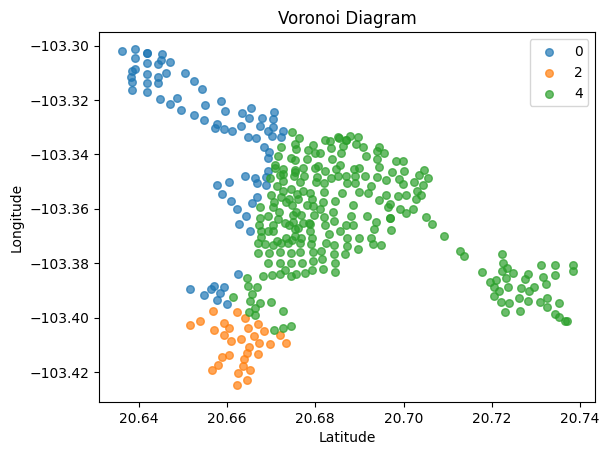

In [21]:
fig, ax = plt.subplots()

# Plot the result
for station in np.unique(stations['Weather_station_id']):
    subset = stations[stations['Weather_station_id'] == station]

    ax.scatter(subset['latitude'], subset['longitude'], alpha=0.7, marker='o', label=station, s=30)

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_title('Voronoi Diagram')
ax.legend()
plt.show()

### Put weather data into Trips df

In [22]:
weather_data = pd.read_csv(
    'open-meteo-data.csv',
    low_memory=True,
    parse_dates=['time'],
    dtype={
        'location_id': np.uint16,
        'rain (mm)': np.float16,
        'relative_humidity_2m': np.uint8
    }
)

weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402000 entries, 0 to 401999
Data columns (total 6 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   location_id               402000 non-null  uint16        
 1   time                      402000 non-null  datetime64[ns]
 2   temperature_2m (°C)       402000 non-null  float64       
 3   rain (mm)                 402000 non-null  float16       
 4   cloud_cover (%)           402000 non-null  int64         
 5   relative_humidity_2m (%)  402000 non-null  int64         
dtypes: datetime64[ns](1), float16(1), float64(1), int64(2), uint16(1)
memory usage: 13.8 MB


In [23]:
weather_data['temperature_2m (°C)'] = weather_data['temperature_2m (°C)'].astype(np.uint8)

In [24]:
weather_data['Hour'] = (weather_data['time'].dt.hour).astype(np.uint8)
weather_data['Day'] = (weather_data['time'].dt.day).astype(np.uint8)
weather_data['Month'] = (weather_data['time'].dt.month).astype(np.uint8)
weather_data['Year'] = (weather_data['time'].dt.year).astype(np.uint16)

weather_data.drop(columns=['time'], inplace=True)

In [25]:
weather_data.rename(columns={'location_id': 'Weather_station_id'}, inplace=True)

In [26]:
weather_data.columns

Index(['Weather_station_id', 'temperature_2m (°C)', 'rain (mm)',
       'cloud_cover (%)', 'relative_humidity_2m (%)', 'Hour', 'Day', 'Month',
       'Year'],
      dtype='object')

In [27]:
travels.columns

Index(['Origin_Id', 'Destination_Id', 'Age', 'Start_hour', 'Start_dayofweek',
       'Start_is_weekend', 'Minute', 'Hour', 'Day', 'Month', 'Year',
       'Duration', 'Start_hour_sin', 'Start_hour_cos', 'origin_lon',
       'origin_lat', 'dest_lon', 'dest_lat', 'Trip_summary', 'Distance'],
      dtype='object')

In [28]:
travels['Weather_station_id'] = travels['Origin_Id'].map(stations.set_index('id')['Weather_station_id'])

travels = travels.merge(
    weather_data,
    on=['Weather_station_id', 'Hour', 'Day', 'Month', 'Year'],
    how='left'
)

In [29]:
travels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25863690 entries, 0 to 25863689
Data columns (total 25 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Origin_Id                 uint16 
 1   Destination_Id            uint16 
 2   Age                       uint8  
 3   Start_hour                uint8  
 4   Start_dayofweek           uint8  
 5   Start_is_weekend          uint8  
 6   Minute                    uint8  
 7   Hour                      uint8  
 8   Day                       uint8  
 9   Month                     uint8  
 10  Year                      uint16 
 11  Duration                  uint16 
 12  Start_hour_sin            float16
 13  Start_hour_cos            float16
 14  origin_lon                float64
 15  origin_lat                float64
 16  dest_lon                  float64
 17  dest_lat                  float64
 18  Trip_summary              uint32 
 19  Distance                  float16
 20  Weather_station_id    

### Save engineered df

In [ ]:
travels.to_csv('trips_engineered.csv', index=True)

## Plot all stations

In [ ]:
# Define borders of the map to our Dataset max and min values
margin = 0.0025

llcrnrlat = stations['latitude'].min() - margin
urcrnrlat = stations['latitude'].max() + margin
llcrnrlon = stations['longitude'].min() - margin
urcrnrlon = stations['longitude'].max() + margin

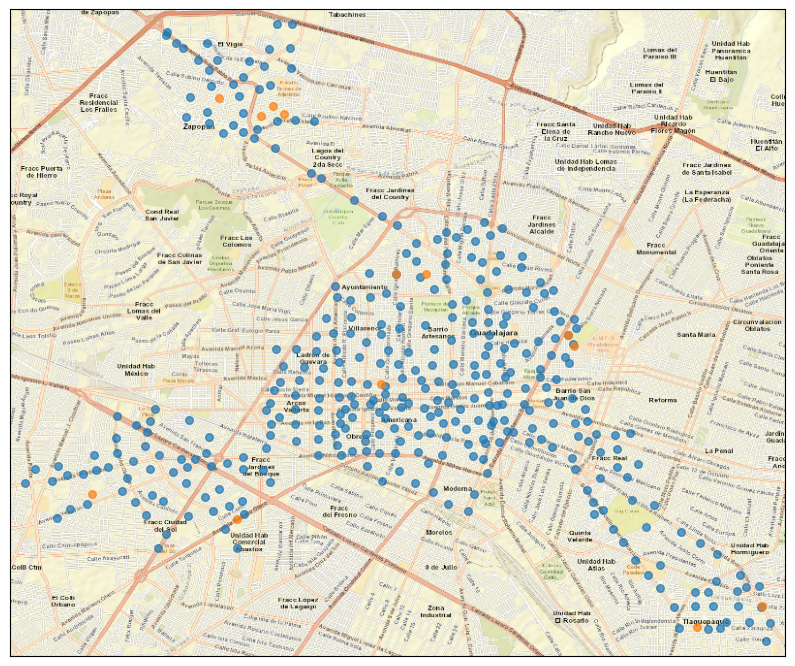

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

m = Basemap(
    epsg=4326,
    llcrnrlat = llcrnrlat,
    urcrnrlat = urcrnrlat,
    llcrnrlon = llcrnrlon,
    urcrnrlon = urcrnrlon,
    resolution = 'l'
)

# Pull our street map image
m.arcgisimage(service='World_Street_Map', xpixels=800, verbose=False)

# Plot status of all stations
for status in stations['status'].unique():
    subset = stations[stations['status'] == status]

    x, y = m(subset['longitude'], subset['latitude'])
    ax.scatter(x, y, alpha=0.7, marker='o', label=status, s=30)

    # for i, row in stations.iterrows():
    #     ax.annotate(row['id'], (row['longitude'], row['latitude']), fontsize=7, ha='center', va='bottom')

plt.title("Todas las estaciones de MiBici")
plt.legend()
fig.show()

In [ ]:
def haversine(lat1, lon1, lat2, lon2, unit='km'):
    # Earth radius in kilometers (mean radius)
    R = 6371.0

    # Convert degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula components
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Calculate distance
    distance = R * c

    # Convert to miles if requested
    if unit == 'mi':
        distance *= 0.621371

    return distance

In [ ]:
station_coords = stations.set_index('id')[['longitude', 'latitude']].apply(lambda id: m(id['longitude'], id['latitude']), axis=1).to_dict()

t = travels.copy()

# # Map origin and destination coordinates to travels
t['origin'] = t['Origin_Id'].map(station_coords)
t['destination'] = t['Destination_Id'].map(station_coords)

# Drop rows with missing coordinates (if any)
t = t.dropna(subset=['origin', 'destination'])

# Extract coordinates into separate columns
t[['origin_lon', 'origin_lat']] = pd.DataFrame(t['origin'].tolist(), index=t.index)
t[['dest_lon', 'dest_lat']] = pd.DataFrame(t['destination'].tolist(), index=t.index)

In [ ]:
# Generate line segments for each travel
segments = list(zip(
    zip(t.origin_lon, t.origin_lat),
    zip(t.dest_lon, t.dest_lat)
))

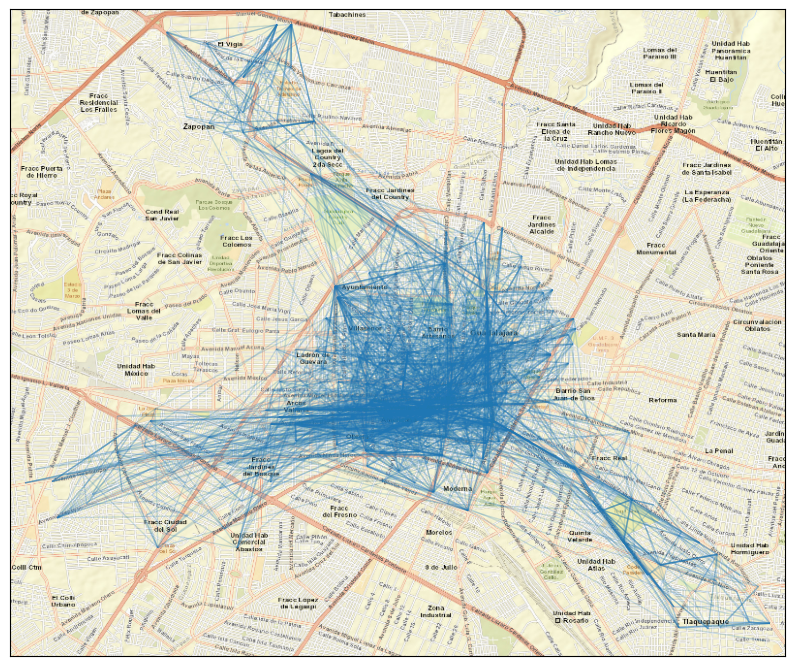

In [ ]:
# Create a LineCollection
lc = LineCollection(segments, alpha=0.2, linewidths=1)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

# Pull our street map image
m.arcgisimage(service='World_Street_Map', xpixels=800, verbose=False)

plt.gca().add_collection(lc)  # Add the lines to the plot
# plt.title('3000 Viajes')
plt.show()